In [1]:
import os, sys
import json
import jsonlines
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from FlagEmbedding import FlagLLMReranker, LayerWiseFlagLLMReranker
from sentence_transformers import CrossEncoder

import requests
import base64
import pickle
import torch

from collections import defaultdict

In [2]:
# Read raw data
test_data_dict = {}
docs_data_dict = {}
for path in glob('./annotated_data/*.json'):
    dset = pd.read_json(path)
    dset_name = path.split('/')[-1].replace('.json', '')
    test_data_dict[dset_name] = dset
    print(f"Loading `{dset_name}` with {len(dset)} data points.")

    # Read context documents
    docs_data = []
    for path in glob(f'./repairbench_docs/{dset_name}_docs/*'):
        json_data = json.load(open(path, 'r'))
        for i in range(len(json_data)):
            json_data[i]['metadata']['chunk_idx'] = i+1
        docs_data += json_data

    docs_data_dict[dset_name] = docs_data
    print(f'Loaded {len(docs_data)} document chunks for `{dset_name}`')
    print()

Loading `repairbench_ko` with 55 data points.
Loaded 162 document chunks for `repairbench_ko`

Loading `repairbench_en` with 373 data points.
Loaded 2224 document chunks for `repairbench_en`

Loading `repairbench_ja` with 222 data points.
Loaded 1429 document chunks for `repairbench_ja`



# BGE-Reranker-v2-MiniCPM Evaluation

In [3]:
# Reranker Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>

reranker = LayerWiseFlagLLMReranker('BAAI/bge-reranker-v2-minicpm-layerwise', use_fp16=False, device="cuda")
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
if os.path.exists('eval_reranker_bge-reranker-v2-minicpm-layerwise.json'):
    eval_dict = json.load(open('eval_reranker_bge-reranker-v2-minicpm-layerwise.json', 'r'))
else:
    eval_dict = {}
    for dset_name, test_df in test_data_dict.items():
        print(f'Running Rerank Evaluation for `{dset_name}`')
        docs_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0]]).tolist()
        silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
        gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
        
        docs_list = test_df['data'].apply(lambda x: [res['snippet'] for res in x['search_results'][0]]).tolist()
        query_list = test_df['data'].apply(lambda x: x['question']).tolist()
    
        k_metrics = {
            k: {
                'silver_correct': 0, 'silver_count': 0, 'any_silver_correct': 0, 'silver_row_count': 0,
                'gold_correct': 0, 'gold_count': 0, 'any_gold_correct': 0, 'gold_row_count': 0
               } for k in ks
        }
        sum_metrics = {}
        for query, docs, docs_uids, silver_uids, gold_uids in tqdm(zip(query_list, docs_list, docs_uids_list, silver_uids_list, gold_uids_list)):
            # Compute Rerank from top-15 search results
            scores = reranker.compute_score([[query, doc] for doc in docs], cutoff_layers=[28])
            rerank_uids = [docs_uids[idx] for idx in sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)]
            
            for k in ks:
                pred_uids = [uid for uid in rerank_uids[:k]]
                if len(silver_uids) > 0:
                    k_metrics[k][f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                    k_metrics[k][f'silver_count'] += len(set(silver_uids))
                    k_metrics[k][f'silver_row_count'] += 1
                if len(gold_uids) > 0:
                    k_metrics[k][f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                    k_metrics[k][f'gold_count'] += len(set(gold_uids))
                    k_metrics[k][f'gold_row_count'] += 1
    
        for k in ks:
            sum_metrics[k] = {
                # 'silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_count'], 
                'gold_acc': k_metrics[k][f'gold_correct'] / k_metrics[k][f'gold_count'],
                # 'any_silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_row_count'], 
                'any_gold_acc': k_metrics[k][f'any_gold_correct'] /k_metrics[k][f'gold_row_count'],
            }
    
        eval_dict[dset_name] = dict(sum_metrics)
    json.dump(eval_dict, open('eval_reranker_bge-reranker-v2-minicpm-layerwise.json', 'w'))

/home/samuelcahyawijaya_cohere_com/miniforge3/envs/sandbox/lib/python3.11/site-packages/FlagEmbedding/inference/reranker/decoder_only/layerwise.py:114: UserWarning: Due to model constraints, `use_bf16` and `use_fp16` cannot both be `False`. Here, `use_fp16` is set to `True` by default.
  warnings.warn("Due to model constraints, `use_bf16` and `use_fp16` cannot both be `False`. Here, `use_fp16` is set to `True` by default.", UserWarning)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

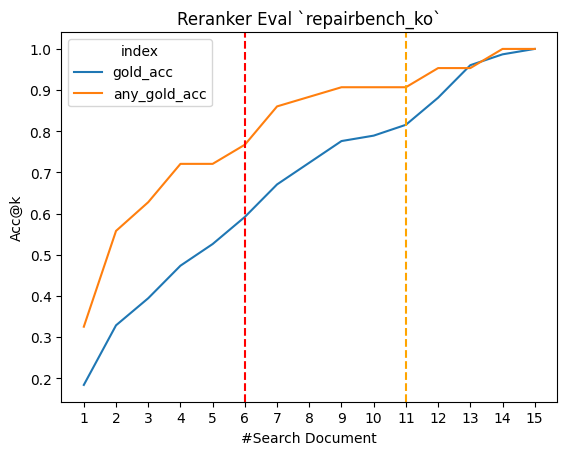

In [4]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

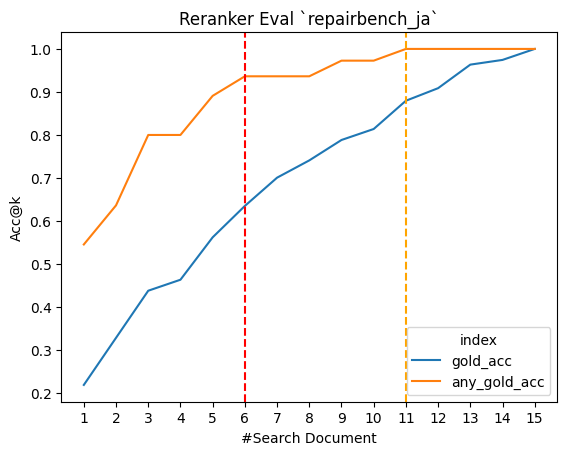

In [5]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

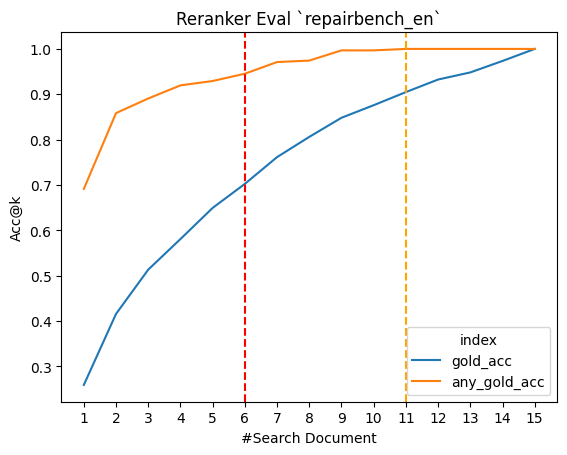

In [6]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

# BGE-Reranker-v2-Gemma Evaluation

In [7]:
# Reranker Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>

reranker = FlagLLMReranker('BAAI/bge-reranker-v2-gemma', use_fp16=False, device="cuda:0")
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
if os.path.exists('eval_reranker_bge-reranker-v2-gemma.json'):
    eval_dict = json.load(open('eval_reranker_bge-reranker-v2-gemma.json', 'r'))
else:
    eval_dict = {}
    for dset_name, test_df in test_data_dict.items():
        print(f'Running Rerank Evaluation for `{dset_name}`')
        docs_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0]]).tolist()
        silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
        gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
        
        docs_list = test_df['data'].apply(lambda x: [res['snippet'] for res in x['search_results'][0]]).tolist()
        query_list = test_df['data'].apply(lambda x: x['question']).tolist()
    
        k_metrics = {
            k: {
                'silver_correct': 0, 'silver_count': 0, 'any_silver_correct': 0, 'silver_row_count': 0,
                'gold_correct': 0, 'gold_count': 0, 'any_gold_correct': 0, 'gold_row_count': 0
               } for k in ks
        }
        sum_metrics = {}
        for query, docs, docs_uids, silver_uids, gold_uids in tqdm(zip(query_list, docs_list, docs_uids_list, silver_uids_list, gold_uids_list)):
            # Compute Rerank from top-15 search results
            scores = reranker.compute_score([[query, doc] for doc in docs])
            rerank_uids = [docs_uids[idx] for idx in sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)]
        
            for k in ks:
                pred_uids = [uid for uid in rerank_uids[:k]]
                if len(silver_uids) > 0:
                    k_metrics[k][f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                    k_metrics[k][f'silver_count'] += len(set(silver_uids))
                    k_metrics[k][f'silver_row_count'] += 1
                if len(gold_uids) > 0:
                    k_metrics[k][f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                    k_metrics[k][f'gold_count'] += len(set(gold_uids))
                    k_metrics[k][f'gold_row_count'] += 1
    
        for k in ks:
            sum_metrics[k] = {
                # 'silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_count'], 
                'gold_acc': k_metrics[k][f'gold_correct'] / k_metrics[k][f'gold_count'],
                # 'any_silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_row_count'], 
                'any_gold_acc': k_metrics[k][f'any_gold_correct'] /k_metrics[k][f'gold_row_count'],
            }
    
        eval_dict[dset_name] = dict(sum_metrics)
    json.dump(eval_dict, open('eval_reranker_bge-reranker-v2-gemma.json', 'w'))

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

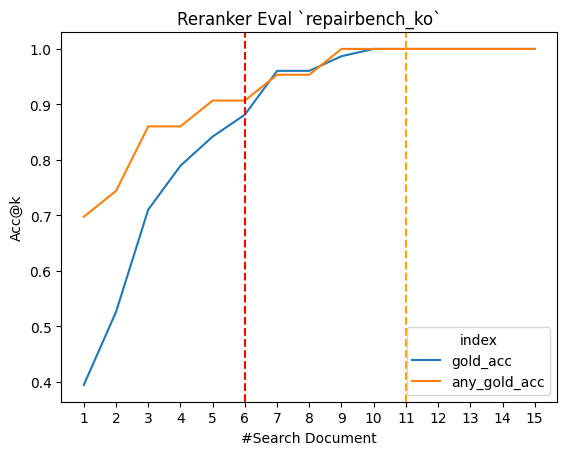

In [8]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

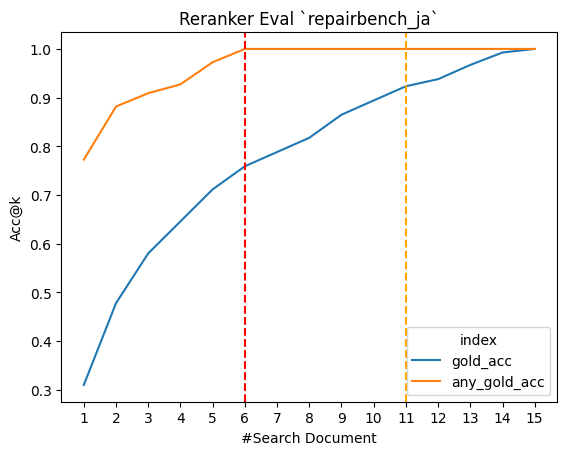

In [9]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

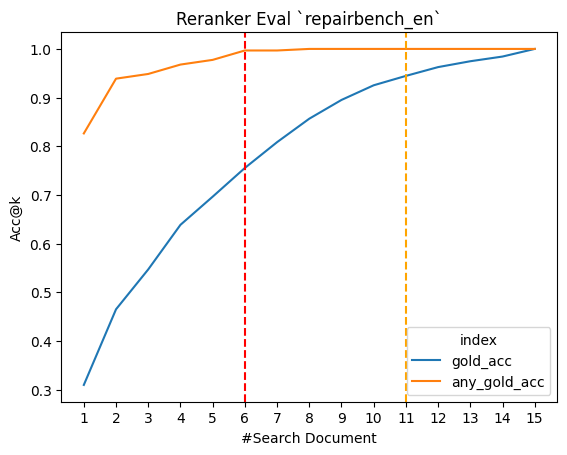

In [10]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

# BGE-Reranker-v2-M3 Evaluation

In [11]:
# Reranker Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>

reranker = FlagLLMReranker('BAAI/bge-reranker-v2-m3', use_fp16=False, device="cuda:0")
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

if os.path.exists('eval_reranker_bge-reranker-v2-m3.json'):
    eval_dict = json.load(open('eval_reranker_bge-reranker-v2-m3.json', 'r'))
else:
    eval_dict = {}
    for dset_name, test_df in test_data_dict.items():
        print(f'Running Rerank Evaluation for `{dset_name}`')
        docs_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0]]).tolist()
        silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
        gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
        
        docs_list = test_df['data'].apply(lambda x: [res['snippet'] for res in x['search_results'][0]]).tolist()
        query_list = test_df['data'].apply(lambda x: x['question']).tolist()
    
        k_metrics = {
            k: {
                'silver_correct': 0, 'silver_count': 0, 'any_silver_correct': 0, 'silver_row_count': 0,
                'gold_correct': 0, 'gold_count': 0, 'any_gold_correct': 0, 'gold_row_count': 0
               } for k in ks
        }
        sum_metrics = {}
        for query, docs, docs_uids, silver_uids, gold_uids in tqdm(zip(query_list, docs_list, docs_uids_list, silver_uids_list, gold_uids_list)):
            # Compute Rerank from top-15 search results
            scores = reranker.compute_score([[query, doc] for doc in docs])
            rerank_uids = [docs_uids[idx] for idx in sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)]
        
            for k in ks:
                pred_uids = [uid for uid in rerank_uids[:k]]
                if len(silver_uids) > 0:
                    k_metrics[k][f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                    k_metrics[k][f'silver_count'] += len(set(silver_uids))
                    k_metrics[k][f'silver_row_count'] += 1
                if len(gold_uids) > 0:
                    k_metrics[k][f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                    k_metrics[k][f'gold_count'] += len(set(gold_uids))
                    k_metrics[k][f'gold_row_count'] += 1
    
        for k in ks:
            sum_metrics[k] = {
                # 'silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_count'], 
                'gold_acc': k_metrics[k][f'gold_correct'] / k_metrics[k][f'gold_count'],
                # 'any_silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_row_count'], 
                'any_gold_acc': k_metrics[k][f'any_gold_correct'] /k_metrics[k][f'gold_row_count'],
            }
    
    
        eval_dict[dset_name] = dict(sum_metrics)
    json.dump(eval_dict, open('eval_reranker_bge-reranker-v2-m3.json', 'w'))

If you want to use `XLMRobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of XLMRobertaForCausalLM were not initialized from the model checkpoint at BAAI/bge-reranker-v2-m3 and are newly initialized: ['lm_head.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


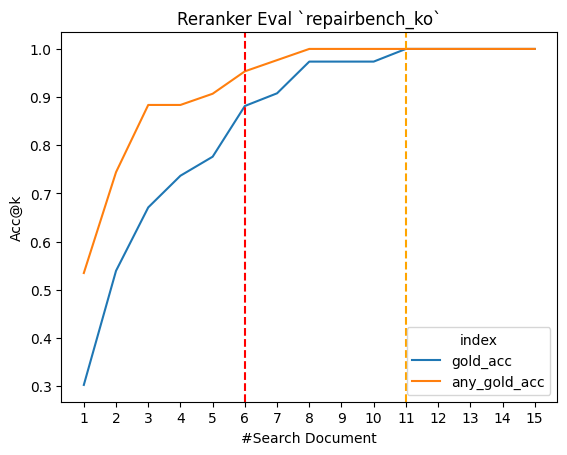

In [12]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

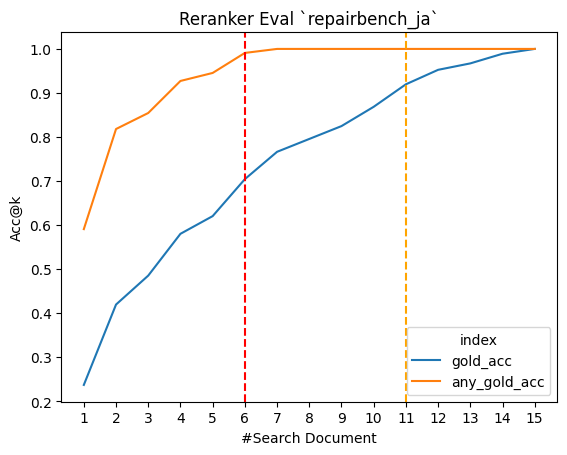

In [13]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

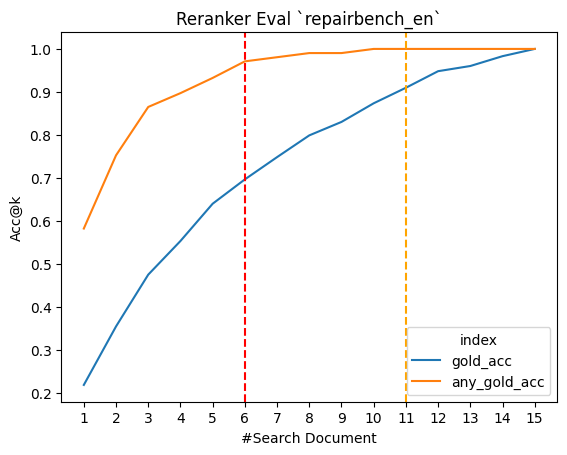

In [14]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

# Jina-Reranker-v2-Base-Multilingual Evaluation

In [17]:
# Reranker Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>

from sentence_transformers import CrossEncoder
reranker = CrossEncoder(
    "jinaai/jina-reranker-v2-base-multilingual",
    automodel_args={"torch_dtype": "auto"},
    trust_remote_code=True,
    device='cuda:0'
)

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

if os.path.exists('eval_reranker_jina-reranker-v2-base-multilingual.json'):
    eval_dict = json.load(open('eval_reranker_jina-reranker-v2-base-multilingual.json', 'r'))
else:
    eval_dict = {}
    for dset_name, test_df in test_data_dict.items():
        print(f'Running Rerank Evaluation for `{dset_name}`')
        docs_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0]]).tolist()
        silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
        gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()
        
        docs_list = test_df['data'].apply(lambda x: [res['snippet'] for res in x['search_results'][0]]).tolist()
        query_list = test_df['data'].apply(lambda x: x['question']).tolist()
        
        k_metrics = {
            k: {
                'silver_correct': 0, 'silver_count': 0, 'any_silver_correct': 0, 'silver_row_count': 0,
                'gold_correct': 0, 'gold_count': 0, 'any_gold_correct': 0, 'gold_row_count': 0
               } for k in ks
        }
        sum_metrics = {}
        for query, docs, docs_uids, silver_uids, gold_uids in tqdm(zip(query_list, docs_list, docs_uids_list, silver_uids_list, gold_uids_list)):
            # Compute Rerank from top-15 search results
            scores = reranker.predict([[query, doc] for doc in docs], convert_to_tensor=True, batch_size=64).tolist()
            rerank_uids = [docs_uids[idx] for idx in sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)]
        
            for k in ks:
                pred_uids = [uid for uid in rerank_uids[:k]]
                if len(silver_uids) > 0:
                    k_metrics[k][f'any_silver_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                    k_metrics[k][f'silver_count'] += len(set(silver_uids))
                    k_metrics[k][f'silver_row_count'] += 1
                if len(gold_uids) > 0:
                    k_metrics[k][f'any_gold_correct'] += 1 if len(set(pred_uids).intersection(set(gold_uids))) > 0 else 0
                    k_metrics[k][f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                    k_metrics[k][f'gold_count'] += len(set(gold_uids))
                    k_metrics[k][f'gold_row_count'] += 1
    
        for k in ks:
            sum_metrics[k] = {
                # 'silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_count'], 
                'gold_acc': k_metrics[k][f'gold_correct'] / k_metrics[k][f'gold_count'],
                # 'any_silver_acc': k_metrics[k][f'silver_correct'] / k_metrics[k][f'silver_row_count'], 
                'any_gold_acc': k_metrics[k][f'any_gold_correct'] /k_metrics[k][f'gold_row_count'],
            }
    
    
        eval_dict[dset_name] = dict(sum_metrics)
    json.dump(eval_dict, open('eval_reranker_jina-reranker-v2-base-multilingual.json', 'w'))

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.


Running Rerank Evaluation for `repairbench_ko`


55it [00:04, 12.56it/s]


Running Rerank Evaluation for `repairbench_en`


373it [00:17, 21.40it/s]


Running Rerank Evaluation for `repairbench_ja`


222it [00:12, 17.33it/s]


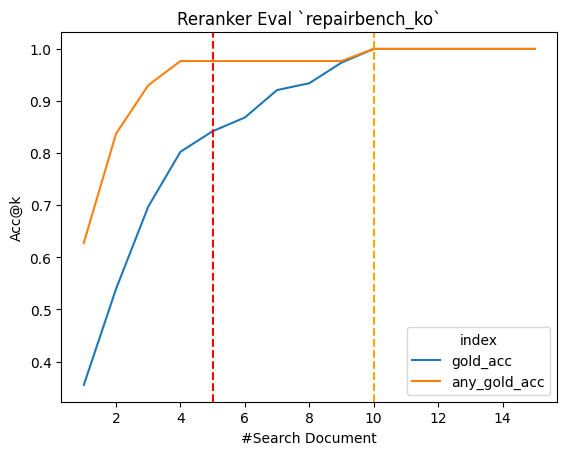

In [18]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

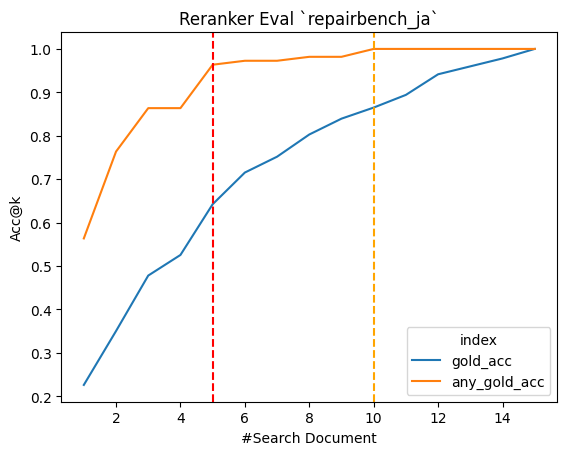

In [19]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()

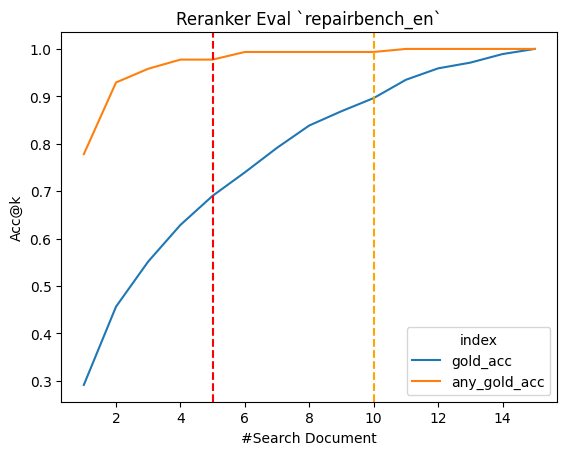

In [20]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Reranker Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=5, ymin=0, ymax=1, color='red', linestyle='--')
plt.axvline(x=10, ymin=0, ymax=1, color='orange', linestyle='--')
plt.show()